In [27]:
#imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np

In [28]:
# load csv
df_college = pd.read_csv('college_data.csv')

nan_count_per_column = df_college.isna().sum()
#print(nan_count_per_column)

# remove NaN
df_college = df_college.dropna() # only leaves 794 rows

In [29]:
# standardize x features
cols = [list(df_college.columns)[i] for i in range(len(list(df_college.columns))) if i not in [0, 5]]
df_standardized = df_college[cols] / df_college[cols].std()

In [30]:
# distribute the dataset into two components X and Y
cols = [list(df_college.columns)[i] for i in range(len(list(df_college.columns))) if i not in [0, 5]]
X = df_standardized[cols].to_numpy()
y = df_college['Retention Rate'].to_numpy()

# Random Forest Regressor

## Feature Importance for Random Forest Regressor

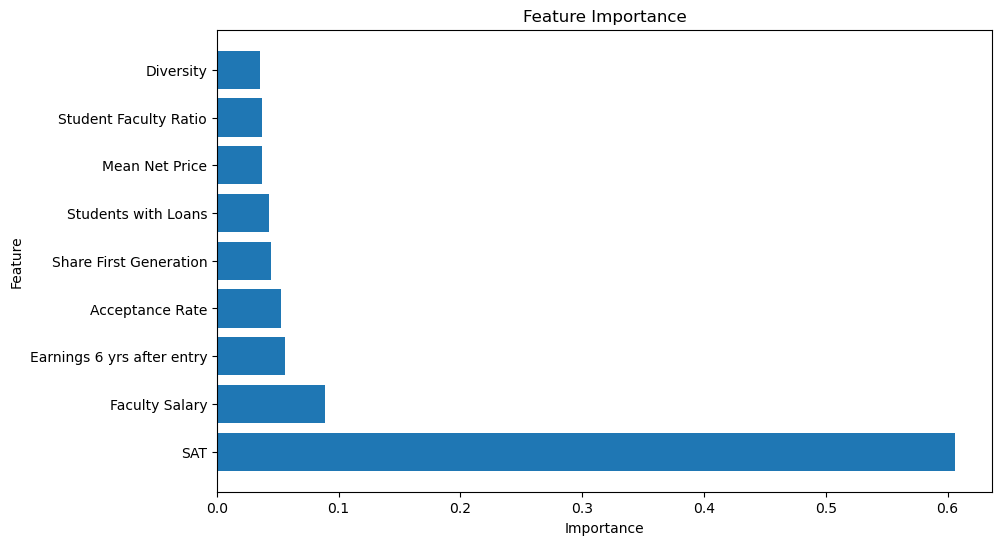

In [31]:
X = df_standardized 
y = df_college['Retention Rate'] 

# cross validate with LOO-CV
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# fit the model on training data
rf_model.fit(X_train, y_train)

# get feature importances
feature_importances = rf_model.feature_importances_

# create a DataFrame to visualize feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [32]:
important_features = ['SAT', 'Faculty Salary', 'Earnings 6 yrs after entry', 'Acceptance Rate', 'Share First Generation', 'Students with Loans', 'Mean Net Price', 'Student Faculty Ratio', 'Diversity']

## Build RFR Models

In [33]:
def rfr(cols):
    """ fits a Random Forest Regressor model to given columns

    Arguments:
        cols (list): names of columns to be fed to RFR

    Returns:
        dictionary of relevant information of resulting RFR model
    """
    X = df_standardized[cols].to_numpy()
    y = df_college['Retention Rate'].to_numpy()

    # split the data (cross validate with LOO-CV)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # create Random Forest Regressor model
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

    # train model
    rf_regressor.fit(X_train, y_train)

    # make predictions on test set
    y_pred = rf_regressor.predict(X_test)

    # evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred) #average absolute difference between the predicted and actual values and can be considered as an accuracy-like measure for regression
    residuals = y_test - y_pred

    return {'mse':mse, 'r2':r2, 'mae':mae, 'residuals':residuals, 'X_test':X_test, 'y_test':y_test, 'y_pred':y_pred, 'features':cols}

In [34]:
def viz_ML(model):
    """ visualize results of an ML model with scatter plots, plots actual values and predicted values

    Arguments:
        model (dict): results of fitting the RFR
    
    Returns:
        None
    """

    num_features = model['X_test'].shape[1]
    X_test = model['X_test']
    y_test = model['y_test']
    y_pred = model['y_pred']
    mse = model['mse']
    r2 = model['r2']
    mae = model['mae']

    if num_features > 1:
        fig, axes = plt.subplots(nrows=1, ncols=num_features, figsize=(15, 5)) 

        for i in range(num_features):
            X_test_feature = model['X_test'][:, i]

            axes[i].scatter(X_test_feature, y_test, label='Actual')
            axes[i].scatter(X_test_feature, y_pred, label='Predicted', color='r', alpha=0.5)
            axes[i].legend()
            if i == 0:
                axes[i].set_ylabel('Retention Rate')
            axes[i].set_title(model['features'][i])

            font_size = 12

        plt.tight_layout()
    
    else:
        plt.scatter(X_test, y_test, label='Actual')
        plt.scatter(X_test, y_pred, label='Predicted', color='r', alpha=0.5)
        plt.legend()
        plt.ylabel('Retention Rate')
        plt.title(model['features'][0])
        font_size = 9

    stats_text = f'MSE: {mse:.4f}, R2: {r2:.4f}, MAE: {mae:.4f}'
    plt.suptitle(stats_text, y=0.01, fontsize=font_size, ha='center')

    plt.show()
    

In [35]:
def plot_model_stats(df, stat, title):

    hover_text = [f'{feature}<br>{stat}: {value}' for feature, value in zip(df['Model Features'], round(df[stat], 6))]

    # plot figure
    fig = go.Figure(data=[
        go.Scatter(x=df.index, y=df[stat], mode='lines', showlegend=False),
        go.Scatter(x=df.index, y=df[stat], mode='markers', marker=dict(size=10), hovertext=hover_text, hoverinfo='text', showlegend=False)
    ])

    # title
    fig.update_layout(title=title)

    # show
    fig.show()

## Top Features

In [36]:
# make models with combinations of top features
top_feature = rfr([important_features[0]])
top_2_feats = rfr(important_features[:2])
top_3_feats = rfr(important_features[:3])
top_4_feats = rfr(important_features[:4])
top_5_feats = rfr(important_features[:5])
top_6_feats = rfr(important_features[:6])
top_7_feats = rfr(important_features[:7])
top_8_feats = rfr(important_features[:8])
all_feats = rfr(important_features)

# get each MSE, r2, and MAE
df_model_stats = pd.DataFrame(columns=['Model Features', 'MSE', 'R^2', 'MAE'])
ls_models = [top_feature, top_2_feats, top_3_feats, top_4_feats, top_5_feats, top_6_feats, top_7_feats, top_8_feats, all_feats]
for m, model_name in zip(ls_models, ['top_feature', 'top_2_feats', 'top_3_feats', 'top_4_feats', 'top_5_feats', 'top_6_feats', 'top_7_feats', 'top_8_feats', 'all_feats']):
    m_stats = {'Model Features': model_name, 'MSE': m['mse'], 'R^2': m['r2'], 'MAE':m['mae']}
    df_model_stats = pd.concat([df_model_stats, pd.DataFrame([m_stats])], ignore_index=True)

df_model_stats

,Model Features,MSE,R^2,MAE
0,top_feature,0.005792,0.542762,0.057820
1,top_2_feats,0.005848,0.538332,0.053873
2,top_3_feats,0.005052,0.601220,0.049098
3,top_4_feats,0.004760,0.624252,0.046697
4,top_5_feats,0.004449,0.648785,0.045021
5,top_6_feats,0.004217,0.667094,0.043480
6,top_7_feats,0.004220,0.666849,0.043522
7,top_8_feats,0.004162,0.671458,0.042640
8,all_feats,0.003998,0.684417,0.042955


In [37]:
plot_model_stats(df_model_stats, 'MSE', 'MSE for RFR Models with Different Top Features')

In [38]:
plot_model_stats(df_model_stats, 'R^2', 'R^2 for RFR Models with Different Top Features')

In [39]:
plot_model_stats(df_model_stats, 'MAE', 'MAE for RFR Models with Different Top Features')

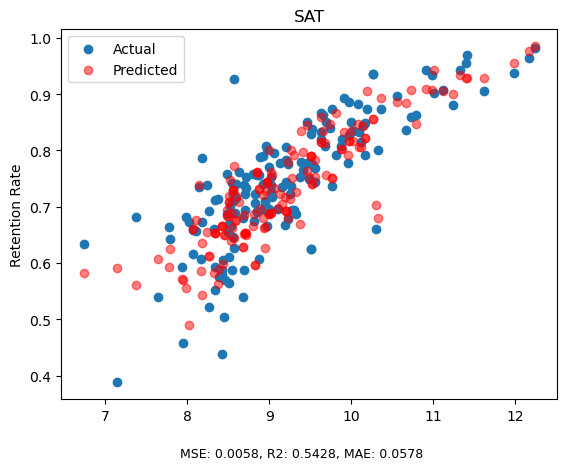

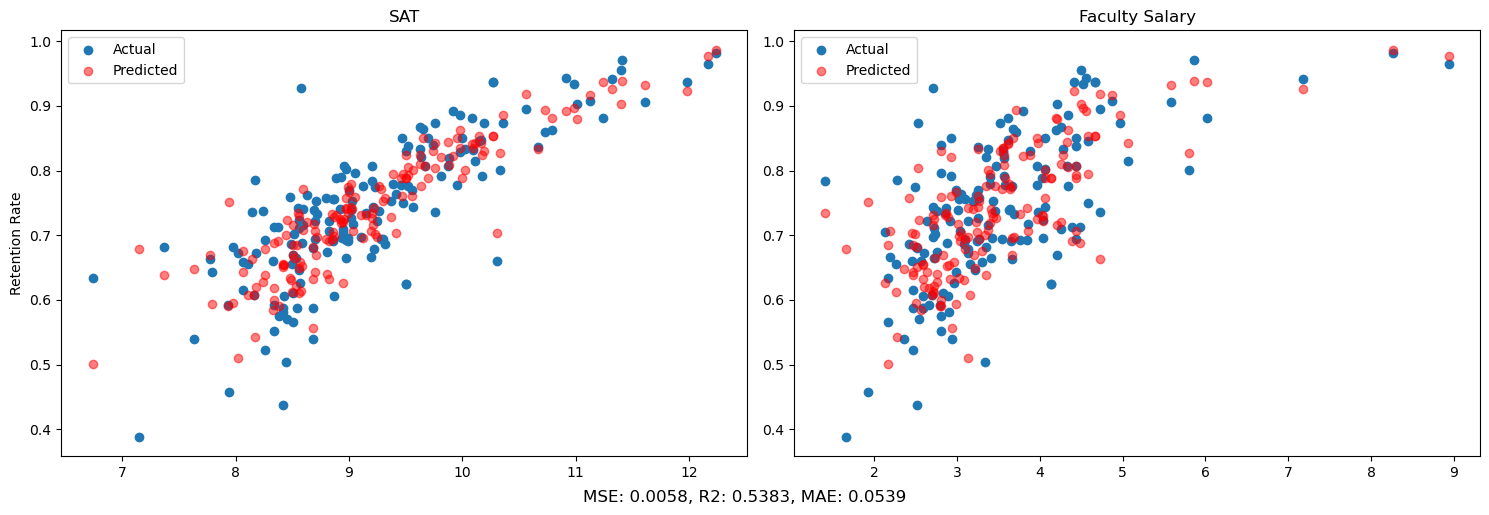

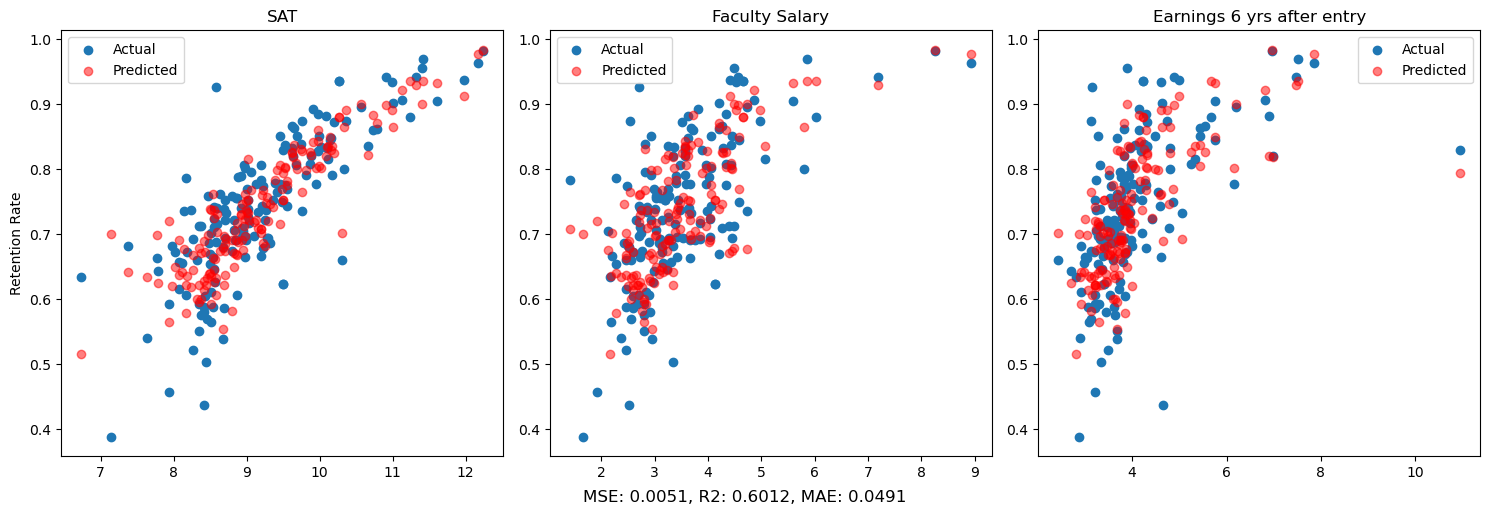

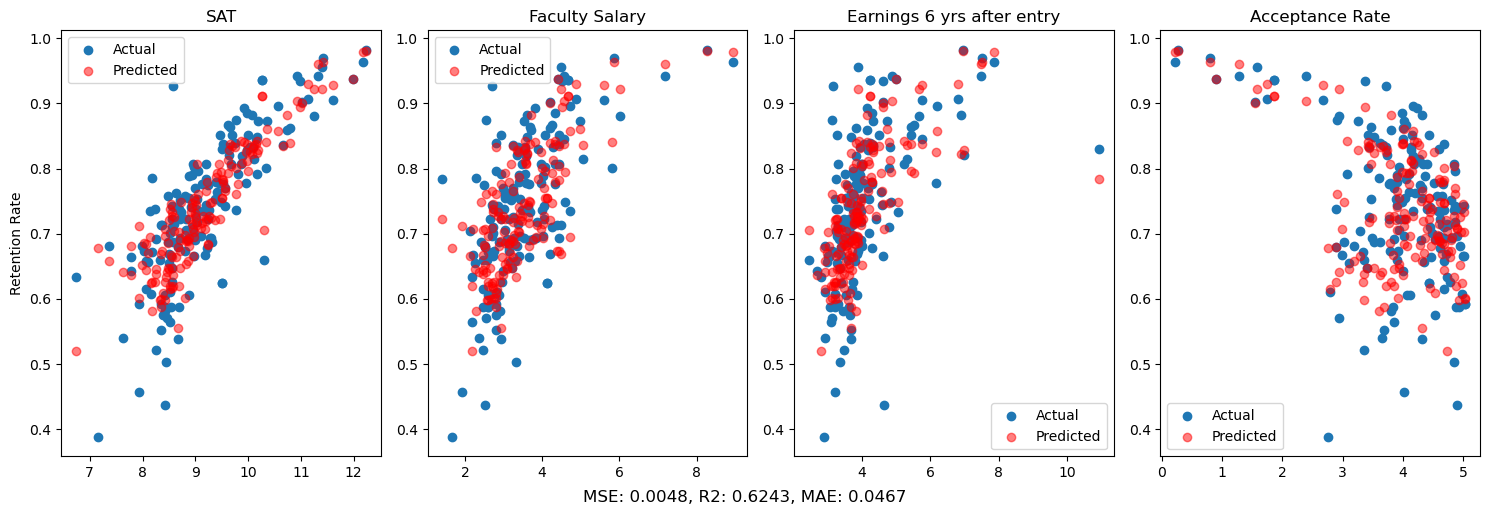

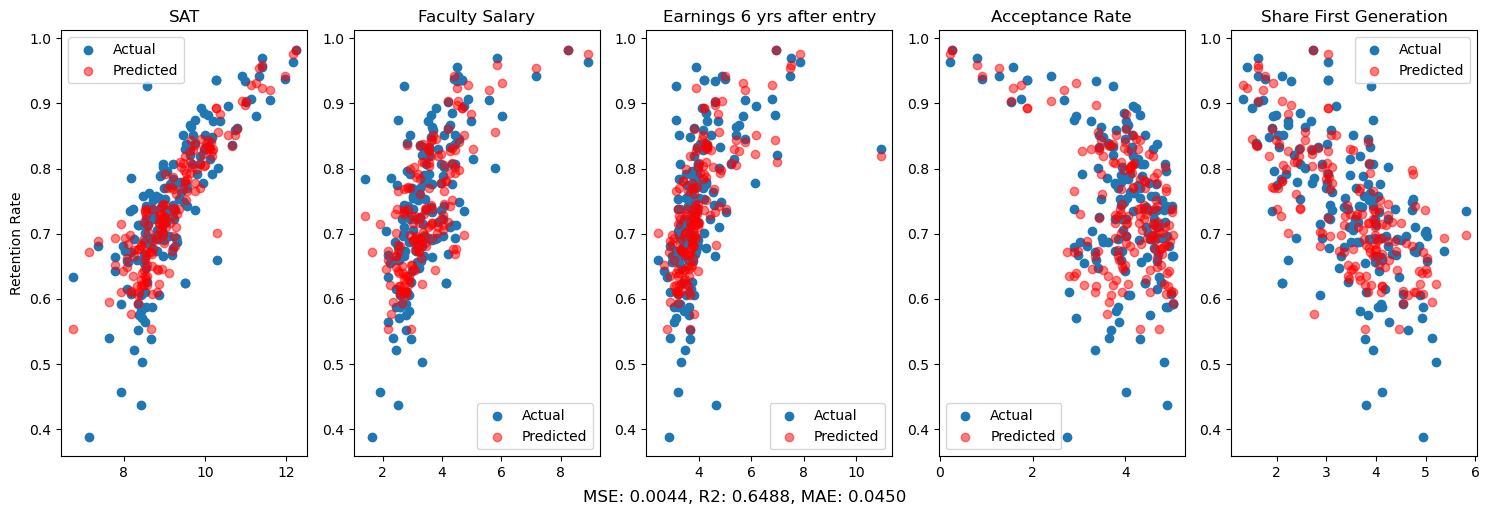

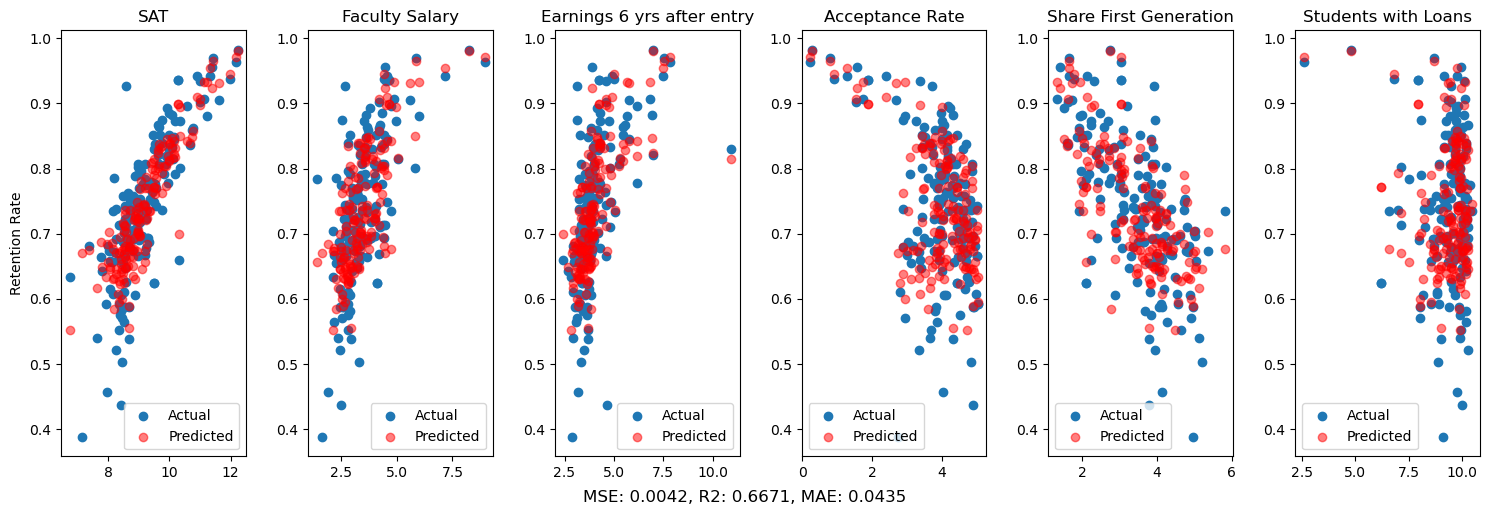

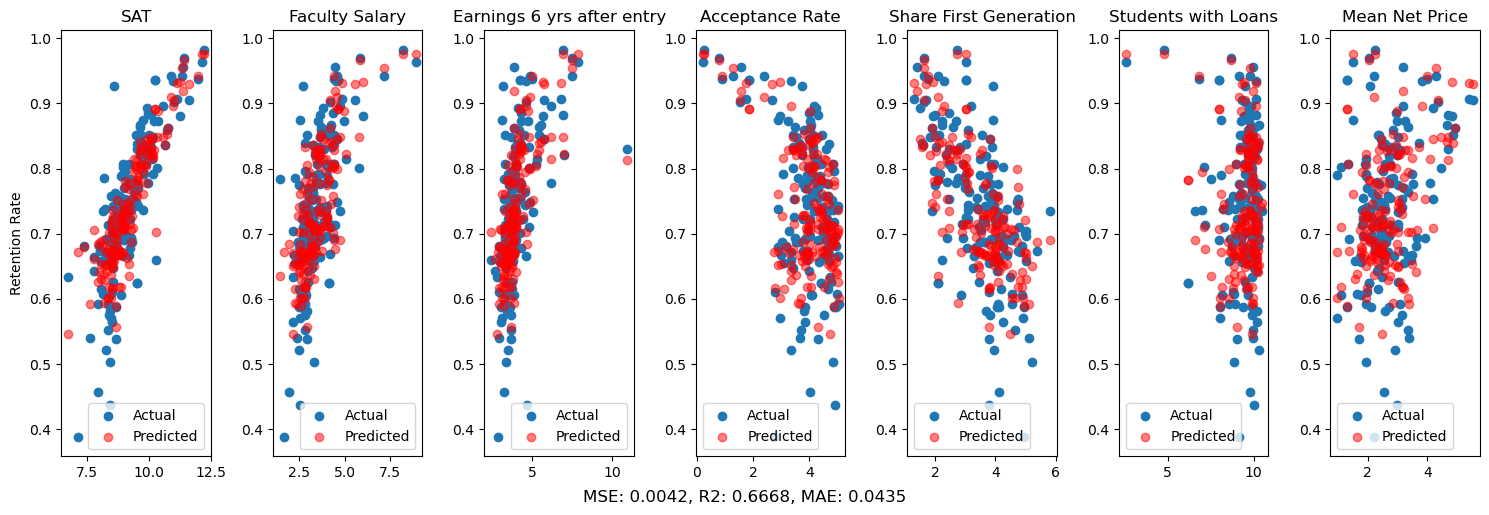

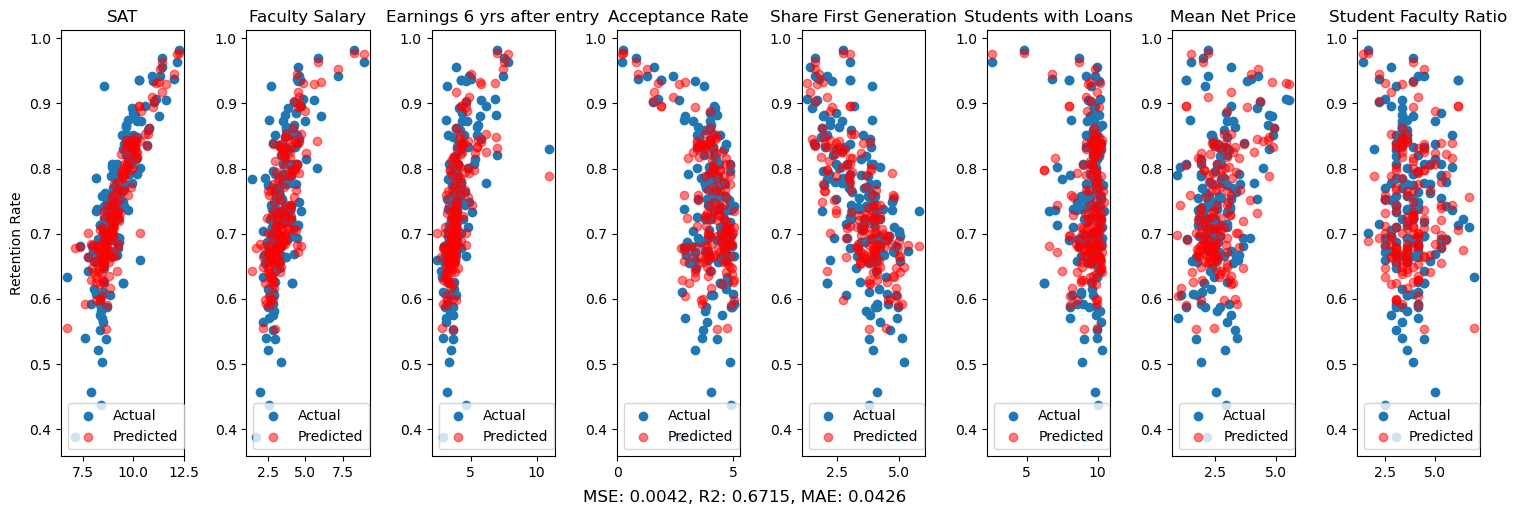

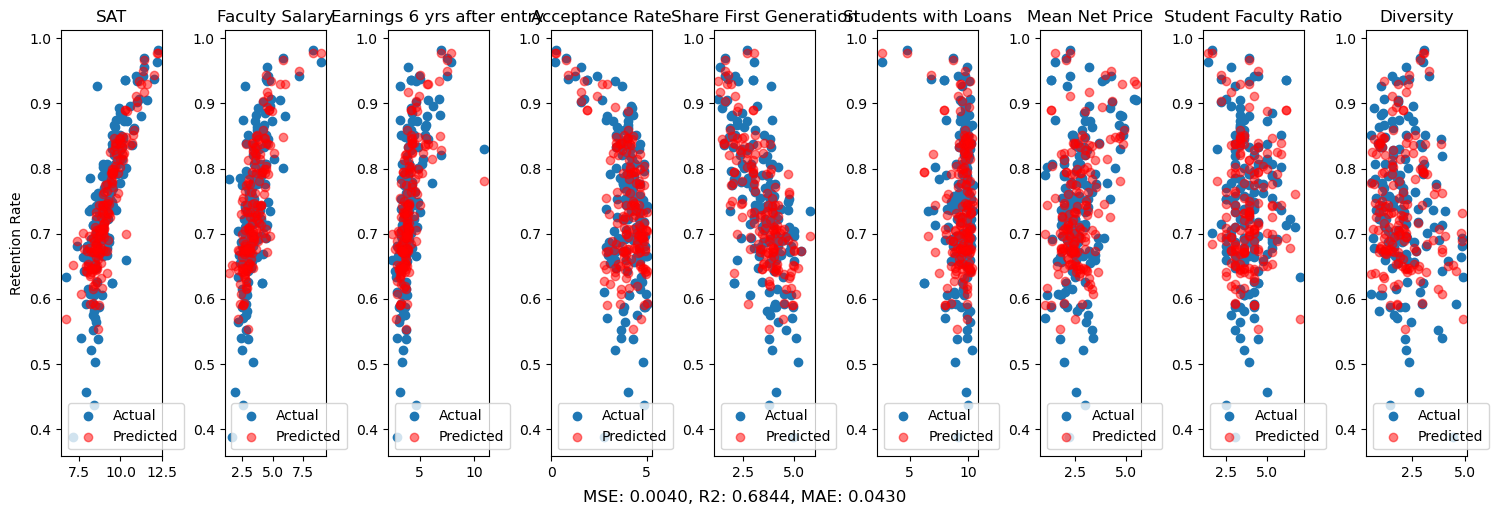

In [40]:
for model in ls_models:
    viz_ML(model)

## Each Feature

In [41]:
# make models for each feature
sat = rfr(['SAT'])
fac_sal = rfr(['Faculty Salary'])
earnings = rfr(['Earnings 6 yrs after entry'])
acc_rate = rfr(['Acceptance Rate'])
first_gen = rfr(['Share First Generation'])
loans = rfr(['Students with Loans'])
price = rfr(['Mean Net Price'])
stud_fac = rfr(['Student Faculty Ratio'])
div = rfr(['Diversity'])


In [42]:
# add to list
ls_models_each_feature = [sat, fac_sal, earnings, acc_rate, first_gen, loans, price, stud_fac, div]

# get each MSE, r2, and MAE
df_each_model_stats = pd.DataFrame(columns=['Model Features', 'MSE', 'R^2', 'MAE'])
for m, model_name in zip(ls_models_each_feature, important_features):
    m_stats = {'Model Features': model_name, 'MSE': m['mse'], 'R^2': m['r2'], 'MAE':m['mae']}
    df_each_model_stats = pd.concat([df_each_model_stats, pd.DataFrame([m_stats])], ignore_index=True)
df_each_model_stats

,Model Features,MSE,R^2,MAE
0,SAT,0.005792,0.542762,0.057820
1,Faculty Salary,0.011175,0.117825,0.079875
2,Earnings 6 yrs after entry,0.010921,0.137879,0.077523
3,Acceptance Rate,0.013812,-0.090307,0.089967
4,Share First Generation,0.011467,0.094833,0.078211
5,Students with Loans,0.017028,-0.344143,0.102793
6,Mean Net Price,0.017239,-0.360863,0.098392
7,Student Faculty Ratio,0.013589,-0.072671,0.093876
8,Diversity,0.014834,-0.170988,0.096194


In [43]:
plot_model_stats(df_each_model_stats, 'MSE', 'MSE for RFR Models with Each Feature')

In [44]:
plot_model_stats(df_each_model_stats, 'R^2', 'R^2 for RFR Models with Each Feature')

In [45]:
plot_model_stats(df_each_model_stats, 'MAE', 'MAE for RFR Models with Each Feature')

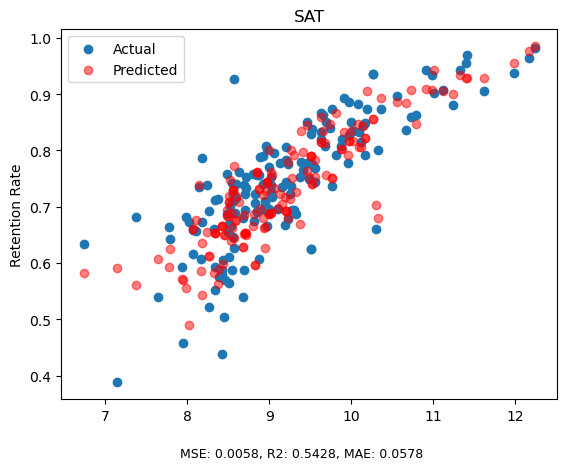

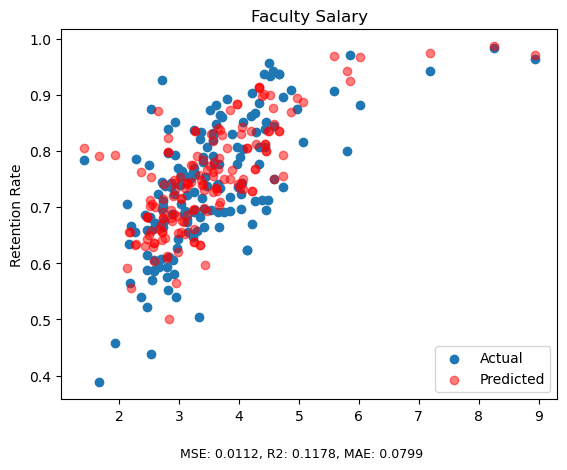

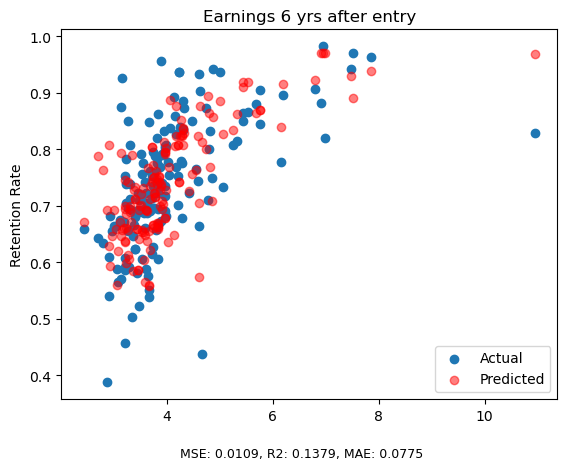

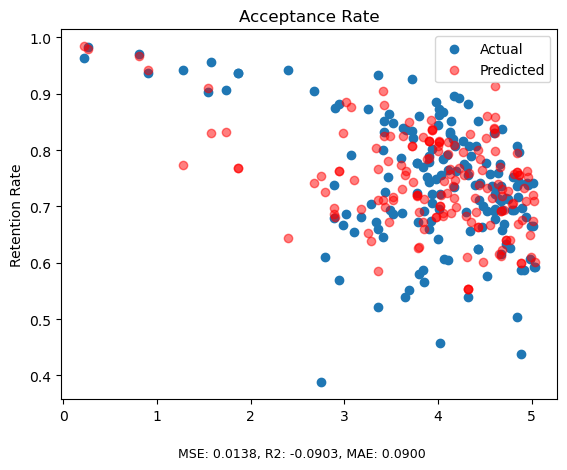

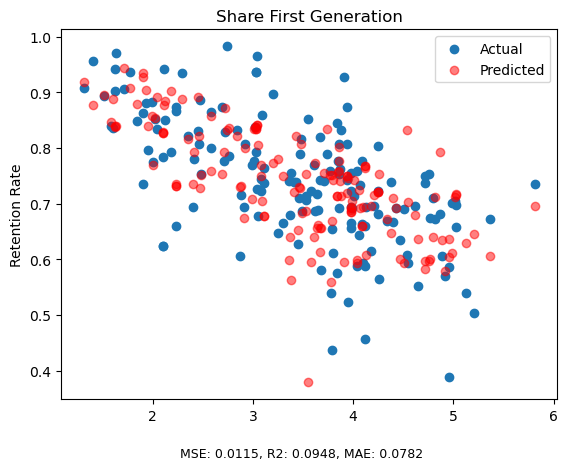

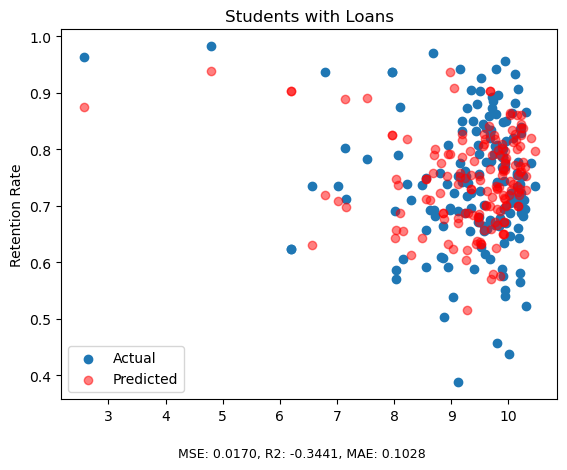

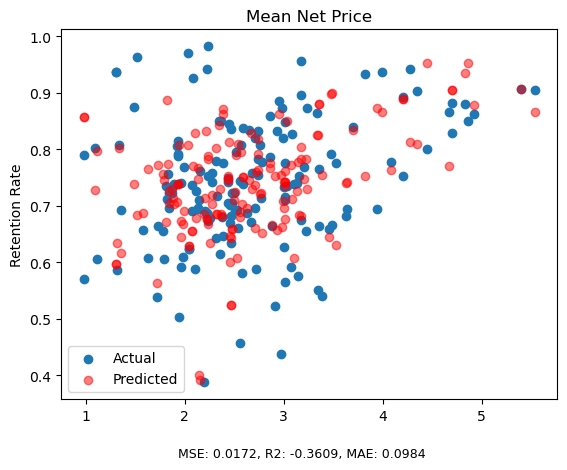

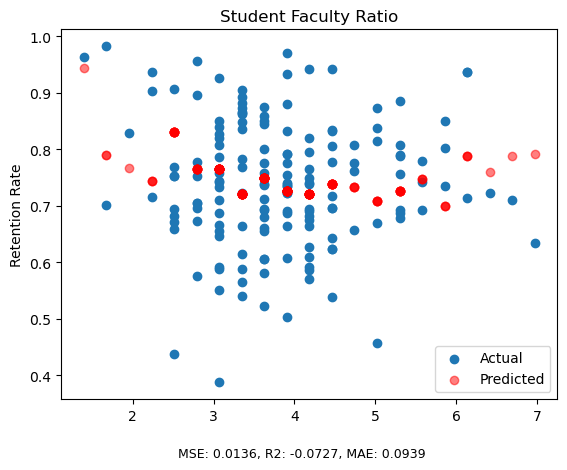

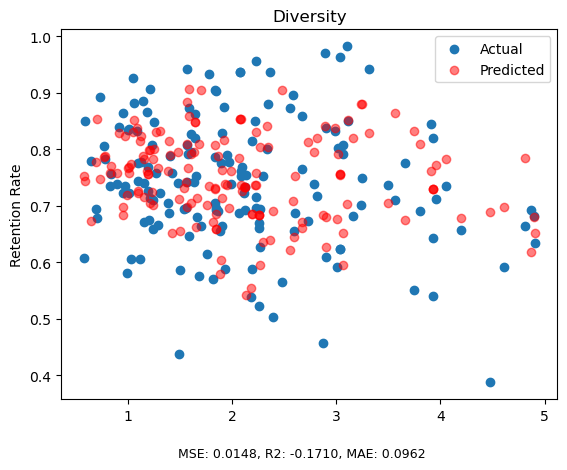

In [46]:
for model in ls_models_each_feature:
    viz_ML(model)

# Multiple Regression
$\hat{y} = b_0 + b_1 x_1 + b_2 x_2 + ... + b_p x_p$

where $x_i$ refer to distinct features.

## Feature Importance for Multiple Regression

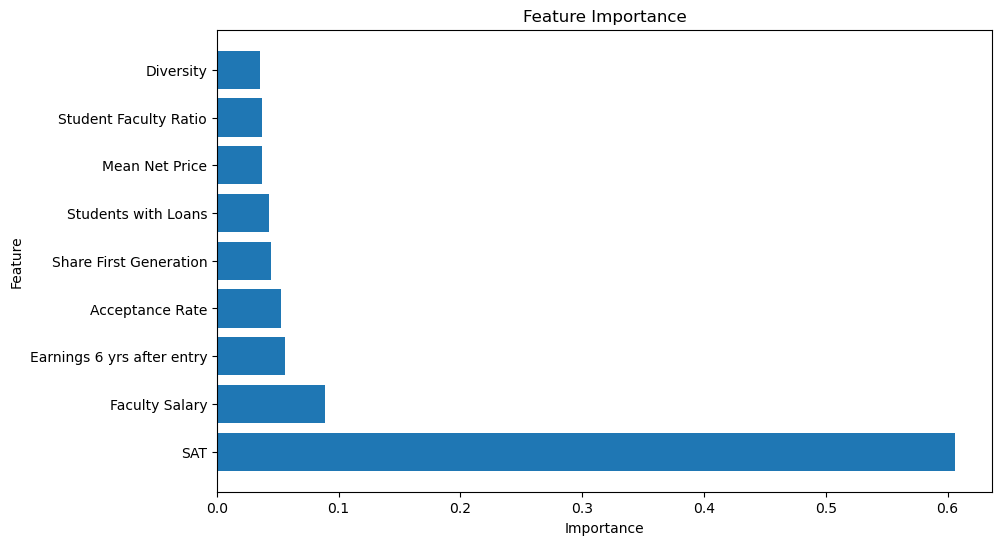

In [47]:
X = df_standardized 
y = df_college['Retention Rate'] 

# cross validate with LOO-CV
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# fit the model on training data
rf_model.fit(X_train, y_train)

# get feature importances
feature_importances = rf_model.feature_importances_

# create a DataFrame to visualize feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

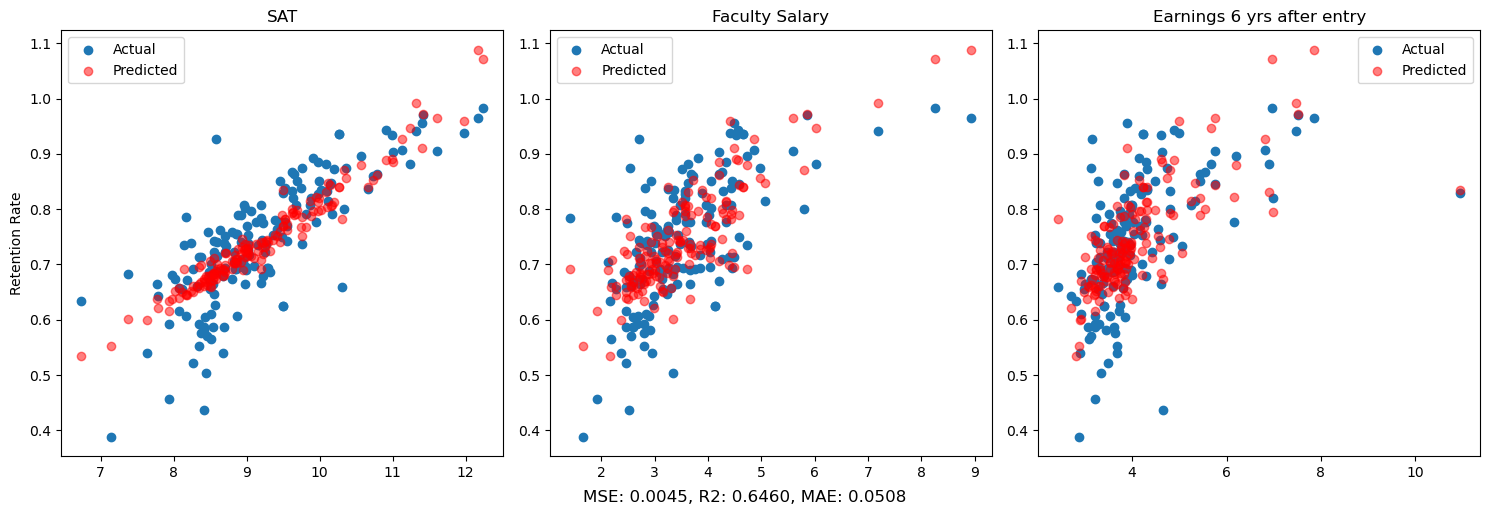

In [48]:
from sklearn.linear_model import LinearRegression

def multiple_regression(cols):
    """ Fits a Multiple Linear Regression model to given columns.

    Arguments:
        cols (list): names of columns to be fed to Multiple Linear Regression.

    Returns:
        dictionary of relevant information of resulting model.
    """
    X = df_standardized[cols].to_numpy()
    y = df_college['Retention Rate'].to_numpy()

    # split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # create Linear Regression object to model the data
    linear_regression = LinearRegression()

    # train the model
    linear_regression.fit(X_train, y_train)

    # make predictions on the test set
    y_pred = linear_regression.predict(X_test)

    # evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    residuals = y_test - y_pred

    return {'mse': mse, 'r2': r2, 'mae': mae, 'residuals': residuals, 'X_test': X_test, 'y_test': y_test, 'y_pred': y_pred, 'features': cols}

# fit a Multiple Linear Regression model with the top 3 features
multiple_reg_top_3_feats = multiple_regression(important_features[:3])

# visualize the results
viz_ML(multiple_reg_top_3_feats)


# LINEAR REGRESSION (CV)

Mean Squared Error (MSE) - Cross-Validated: 0.00495883980030237
R-squared (R2) Score - Cross-Validated: 0.6307167182210377


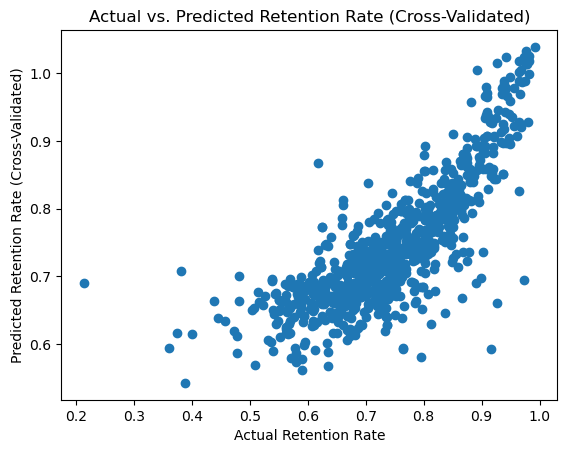

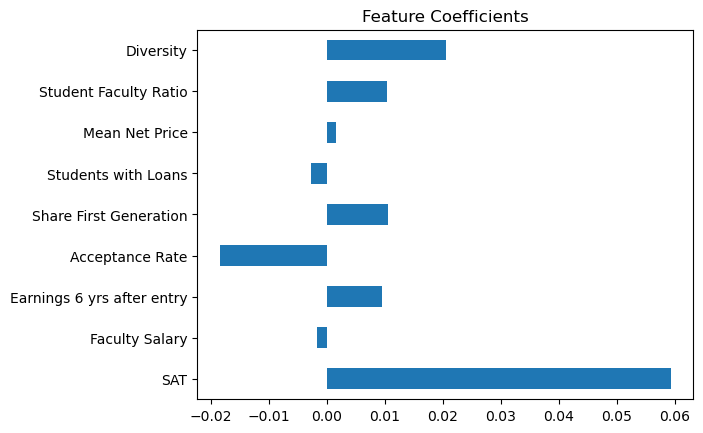

In [49]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.model_selection import KFold
import seaborn as sns

important_features = ['SAT', 'Faculty Salary', 'Earnings 6 yrs after entry', 'Acceptance Rate', 
                      'Share First Generation', 'Students with Loans', 'Mean Net Price', 
                      'Student Faculty Ratio', 'Diversity']
X = df_standardized
y = df_college['Retention Rate'].to_numpy()

# creating a linear regression model
model = LinearRegression()

# fit the model
model.fit(X, y)

# cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# cross-validated predictions
y_cv_pred = cross_val_predict(model, X, y, cv=kf)

# rvaluating the model
mse_cv = mean_squared_error(y, y_cv_pred)
r2_cv = r2_score(y, y_cv_pred)

print(f'Mean Squared Error (MSE) - Cross-Validated: {mse_cv}')
print(f'R-squared (R2) Score - Cross-Validated: {r2_cv}')

# plotting the predicted vs. actual values
plt.scatter(y, y_cv_pred)
plt.xlabel("Actual Retention Rate")
plt.ylabel("Predicted Retention Rate (Cross-Validated)")
plt.title("Actual vs. Predicted Retention Rate (Cross-Validated)")
plt.show()

# displaying feature importance without absolute values
coefficients = pd.Series(model.coef_, index=important_features)
coefficients.plot(kind='barh')
plt.title('Feature Coefficients')
plt.show()

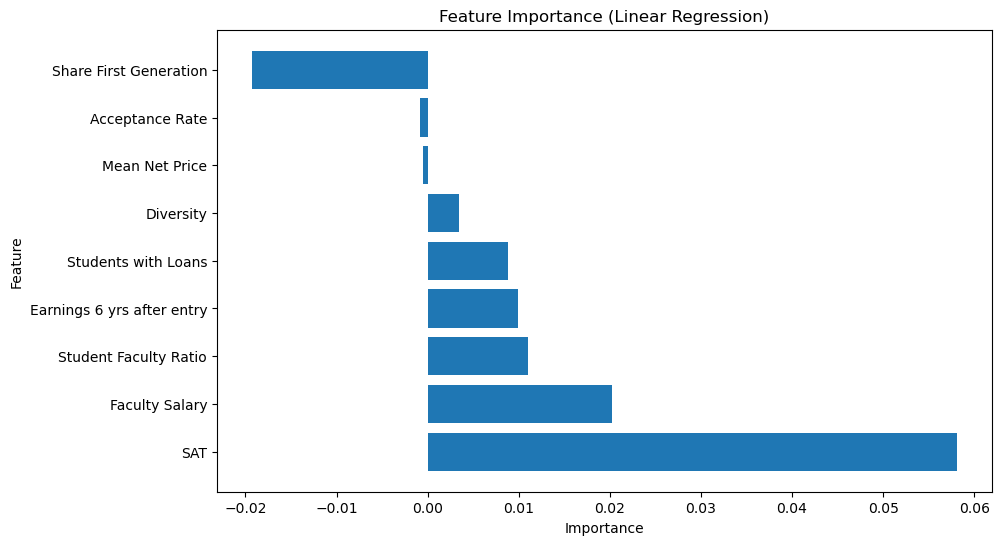

In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Extracting features and target variable
X = df_standardized
y = df_college['Retention Rate'].to_numpy()
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a linear regression model
lr_model = LinearRegression()

# Fitting the model on training data
lr_model.fit(X_train, y_train)

# Getting feature importances (coefficients)
feature_importances = lr_model.coef_

# Creating a DataFrame to visualize feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sorting the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Linear Regression)')
plt.show()

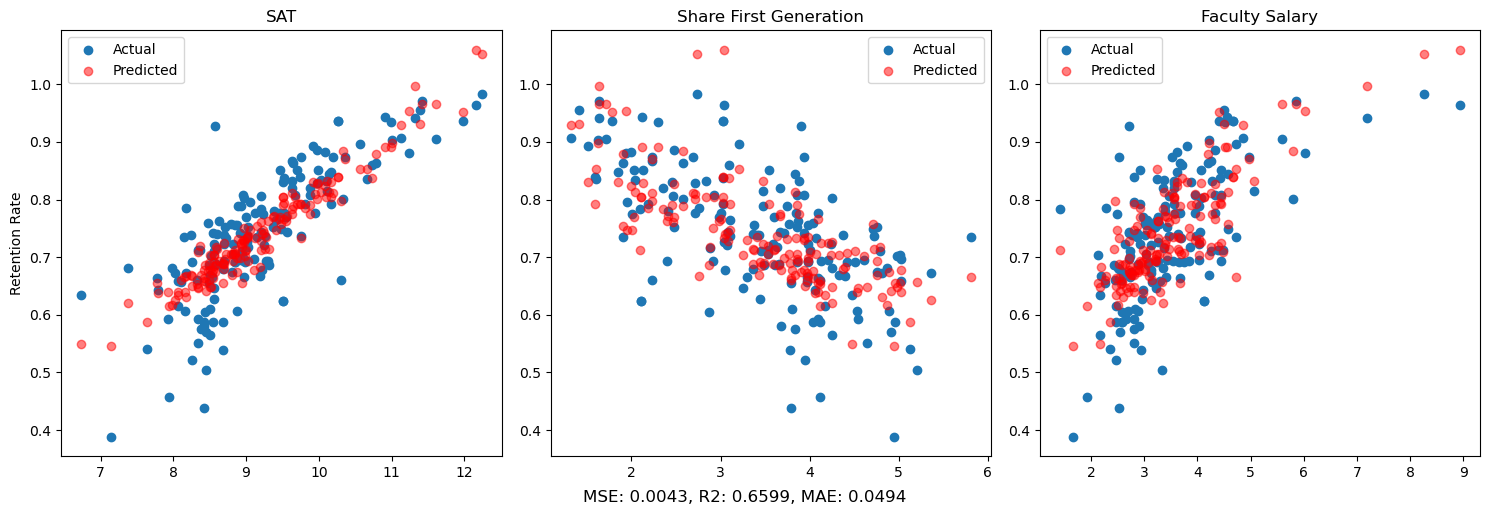

In [51]:
from sklearn.linear_model import LinearRegression

def multiple_regression(cols):
    """ Fits a Multiple Linear Regression model to given columns.

    Arguments:
        cols (list): names of columns to be fed to Multiple Linear Regression.

    Returns:
        dictionary of relevant information of resulting model.
    """
    X = df_standardized[cols].to_numpy()
    y = df_college['Retention Rate'].to_numpy()

    # split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # create Linear Regression object to model the data
    linear_regression = LinearRegression()

    # train the model
    linear_regression.fit(X_train, y_train)

    # make predictions on the test set
    y_pred = linear_regression.predict(X_test)

    # evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    residuals = y_test - y_pred

    return {'mse': mse, 'r2': r2, 'mae': mae, 'residuals': residuals, 'X_test': X_test, 'y_test': y_test, 'y_pred': y_pred, 'features': cols}

# fit a Multiple Linear Regression model with the top 3 features
multiple_reg_top_3_feats = multiple_regression(['SAT', 'Share First Generation', 'Faculty Salary'])

# visualize the results
viz_ML(multiple_reg_top_3_feats)

# Conclusions from Plots

#### Decide Minimum Amount of Top Features to Include
Based on *'MSE for RFR Models with Different Top Features'*, the model with the top 3 features (SAT, Faculty Salary, and Earnings 6 yrs after entry), has a significantly lower MSE than the model of the top feature or the top two features. The MSE of the top 4 features (0.004760) is not significantly lower than that of the top 3 features (0.005052). The model of the top 3 features is the point at which the MSEs of the different models start to be more similar to each other. 

Based on *'$R^2$ for RFR Models with Different Top Features'*, the $R^2$ value of the top 3 features (0.601220) is much greater than that of the top 1 or 2 features (0.542762 and 0.538332, respectively). The model of the top 3 features is the point at which the $R^2s$ of the different models start to be more similar to each other. 

Based on *'MAE for RFR Models with Different Top Features'*, the MAE of the top 3 features marks an elbow in the graph; it marks the point when the MAEs of models with more increasingly more features become less different. 

These results all show that the model with the top 1 and 2 features should be disregarded from our considerations. The top feature, SAT scores, is the most impactful on a school's retention rate, but SAT scores alone are not enough to predict retention rate accurately. Therefore, we should include a minimum of the top 3 features. 

#### Decide Maximum Amount of Top Features to Include
In general, as more features are added, the MSEs and MAEs of the models decrease while the $R^2$ increases. However, 

The model with the top 4 features has a lower MSE, higher $R^2$, and lower MAE than those values of the model with the top 4 features.
TODO - add more